In [4]:
from utils import *
import torch

In [5]:
# Load EEG data
# path = '/expanse/projects/nemar/child-mind-dtyoung/'
path = './data/'
winLength = 2
numChan = 24
srate = 128
feature = 'topo'
one_channel = True


X_train shape: 71138, (1, 24, 72)
Y_train shape: 71138, ()
X_val shape: 39641, (1, 24, 72)
Y_val shape: 39641, ()


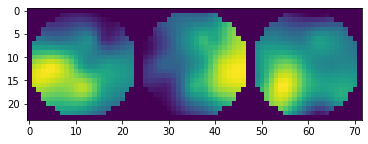

In [6]:

role = 'train'
train_data = load_data(path, role, winLength, numChan, srate, feature, one_channel)
print(f'X_train shape: {len(train_data)}, {train_data[0][0].shape}')
print(f'Y_train shape: {len(train_data)}, {train_data[0][1].shape}')

role = 'val'
val_data = load_data(path, role, winLength, numChan, srate, feature, one_channel)
print(f'X_val shape: {len(val_data)}, {val_data[0][0].shape}')
print(f'Y_val shape: {len(val_data)}, {val_data[0][1].shape}')
plot_EEG(train_data, feature, numChan, one_channel)

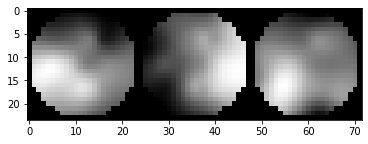

In [11]:
x_data = train_data[:][0]
sample = 2
image = np.reshape(x_data[sample], (x_data[sample].shape[1],x_data[sample].shape[2]))
plt.imshow(image.astype('int32'), cmap='gray', vmin=0, vmax=255)

In [3]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [7]:
def check_accuracy(loader, model, logger):
    if loader.dataset.train:
        logger.log('Checking accuracy on training set')
    elif loader.dataset.val:
        logger.log('Checking accuracy on validation set')
    else:
        logger.log('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        logger.log('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        return acc

In [8]:
def train(model, optimizer, logger, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                logger.writer.add_scalar("Loss/train", loss.item(), e*len(loader_train)+t)
                logger.log('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
        train_acc = check_accuracy(loader_train, model)
        logger.writer.add_scalar("Acc/train", train_acc, e)        
        val_acc = check_accuracy(loader_val, model)
        logger.writer.add_scalar("Acc/valid", val_acc, e)        
        logger.log()
        
        # Save model every 20 epochs
        if e > 0 and e % 10 == 0:
            logger.save_model(model,f"epoch{e}")
        elif val_acc >= 0.83:
            logger.save_model(model,f"valacc83-epoch{e}")
        elif val_acc >= 0.84:
            logger.save_model(model,f"valacc84-epoch{e}")
    # save final model
    logger.save_model(model,f"epoch{e}")
    return model

In [3]:
model = create_model('original',feature)
print(model)
from pytorch_model_summary import summary
print(summary(model, torch.zeros((1, 1, 24, 72)), show_input=False))

Sequential(
  (convolution): Sequential(
    (0): Conv2d(1, 100, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(100, 300, kernel_size=(2, 3), stride=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.25, inplace=False)
    (12): Conv2d(300, 300, kernel_size=(1, 7), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=(1, 2), stride=1, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.25, inplace=False)
    (16): Conv2d(300, 100, kernel_size=(1, 3), stride=(1, 1), padding=(1, 1))
    (17): Conv2d(100, 100, kernel_size=(1, 3), strid

In [11]:
def test_model(model, test_data, subj_csv):
    # one-segment test
    logger.log('Testing model accuracy using 1-segment metric')
    loader_test = DataLoader(test_data, batch_size=70)
    per_sample_acc = check_accuracy(loader_test, model)

    # 40-segment test
    logger.log('Testing model accuracy using 40-segment per subject metric')
    with open(subj_csv, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
        subjIDs = [row[0] for row in spamreader]
    unique_subjs,indices = np.unique(subjIDs,return_index=True)

    iterable_test_data = list(iter(DataLoader(test_data, batch_size=1)))
    num_correct = []
    for subj,idx in zip(unique_subjs,indices):
    #     print(f'Subj {subj} - gender {iterable_test_data[idx][1]}')
        data = iterable_test_data[idx:idx+40]
        #print(np.sum([y for _,y in data]))
        assert 40 == np.sum([y for _,y in data]) or 0 == np.sum([y for _,y in data])
        preds = []
        correct = 0
        with torch.no_grad():
            for x,y in data:
                x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
                correct = y
                scores = model(x)
                _, pred = scores.max(1)
                preds.append(pred)
        final_pred = (torch.mean(torch.FloatTensor(preds)) > 0.5).sum()
        num_correct.append((final_pred == correct).sum())
    #print(len(num_correct))
    acc = float(np.sum(num_correct)) / len(unique_subjs)
    logger.log('Got %d / %d correct (%.2f)' % (np.sum(num_correct), len(unique_subjs), 100 * acc))
    return per_sample_acc, acc

In [12]:
def run_experiment(seed, model_name, feature, num_epoch, logger):
    model = create_model()
    logger.set_model_save_location(f'{model_name}-{feature}')
    experiment = f'{model_name}-{feature}-seed{seed}'
    logger.set_experiment(experiment)

    np.random.seed(seed)
    torch.manual_seed(seed)

    # toggle between learning rate and batch size values 

    optimizer = torch.optim.Adamax(model.parameters(), lr=0.002, weight_decay=0.001)
    model = train(model, optimizer, epochs=num_epoch, logger)
    
    # Testing
#     logger.log('Testing on balanced test set')
#     test_data_balanced = load_data(path, 'test', winLength, numChan, srate, feature,'v2')
#     sample_acc1, subject_acc1 = test_model(model, test_data_balanced, path + 'test_subjIDs.csv')

#     logger.log('Testing on all-male test set')
#     test_data_all_male = load_data(path, 'test', winLength, numChan, srate, feature,'v3')
#     sample_acc2, subject_acc2 = test_model(model, test_data_all_male, path + 'test_subjIDs_more_test.csv')
    
    return model

In [ ]:
logger = Logger()

batch_size = 70 # original
loader_train = DataLoader(train_data, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(val_data, batch_size=batch_size)
for s in range(10):
    model = run_experiment(s, 'original', 'topo',70)

In [13]:
def test_all_seeds(model_name, epoch,isBalanced):
    if isBalanced:
        logger.log('Testing on balanced test set')
        test_data = load_data(path, 'test', winLength, numChan, srate, feature)
        subjIDs_file = 'data/test_subjIDs_fewer_subjects.csv'
    else:
        logger.log('Testing on all male test set')
        test_data = load_data(path, 'test', winLength, numChan, srate, feature,'all_male')
        subjIDs_file = 'data/test_subjIDs_allmale_fewer_subjects.csv'

    sample_acc = []
    subject_acc = []
    for s in range(10):
        model = create_model()
        model.load_state_dict(torch.load(f'saved-model/{model_name}-seed{s}-epoch{epoch}'))
        model.to(device=device)
        sam_acc, sub_acc = test_model(model, test_data,subjIDs_file)
        sample_acc.append(sam_acc)
        subject_acc.append(sub_acc)
        
    sample_acc = np.multiply(sample_acc,100)
    subject_acc = np.multiply(subject_acc,100)
    return sample_acc, subject_acc

In [4]:
logger = Logger(mode='debug')
role = 'test'
test_data = load_data(path, role, winLength, numChan, srate, feature, one_channel)

sample_acc, subject_acc = test_all_seeds("saved-model/original-topo/model-original-topo", 'original',feature,test_data,'data/test_subjIDs_fewer_subjects.csv',10, 10,device, dtype,logger)
min_sample = np.min(sample_acc)
max_sample = np.max(sample_acc)
mean_sample = np.mean(sample_acc)
std_sample = np.std(sample_acc)

min_subj = np.min(subject_acc)
max_subj = np.max(subject_acc)
mean_subj = np.mean(subject_acc)
std_subj = np.std(subject_acc)

logger.log("Per sample")
logger.log(f"Min: {min_sample}, Max: {max_sample}, Mean: {mean_sample}, STDEV: {std_sample}")

logger.log("Per subject")
logger.log(f"Min: {min_subj}, Max: {max_subj}, Mean: {mean_subj}, STDEV: {std_subj}")


Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 12523 / 15925 correct (78.64)
Testing model accuracy using 40-segment per subject metric
Got 163 / 197 correct (82.74)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 12570 / 15925 correct (78.93)
Testing model accuracy using 40-segment per subject metric
Got 161 / 197 correct (81.73)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 12608 / 15925 correct (79.17)
Testing model accuracy using 40-segment per subject metric
Got 162 / 197 correct (82.23)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 12508 / 15925 correct (78.54)
Testing model accuracy using 40-segment per subject metric
Got 163 / 197 correct (82.74)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 12486 / 15925 correct (78.41)
Testing model accuracy using 40-segment per subject metric
Got 160 / 197 correct (81.22)
Testi

In [14]:
logger = Logger(mode='debug')
epochs = [20, 30, 40, 60, 69]

with open("original-topo-test-results-balanced.csv", 'w') as out:
    out.write('epoch,min_sam,max_sam,mean_sam,std_sam,min_subj,max_subj,mean_subj,std_subj\n')
    for epoch in epochs:
        sample_acc, subject_acc = test_all_seeds(model_name="original-topo/model-original-topo", epoch=epoch, isBalanced=True)

        min_sample = np.min(sample_acc)
        max_sample = np.max(sample_acc)
        mean_sample = np.mean(sample_acc)
        std_sample = np.std(sample_acc)

        min_subj = np.min(subject_acc)
        max_subj = np.max(subject_acc)
        mean_subj = np.mean(subject_acc)
        std_subj = np.std(subject_acc)

        logger.log("Per sample")
        logger.log(f"Min: {min_sample}, Max: {max_sample}, Mean: {mean_sample}, STDEV: {std_sample}")

        logger.log("Per subject")
        logger.log(f"Min: {min_subj}, Max: {max_subj}, Mean: {mean_subj}, STDEV: {std_subj}")
        out.write(f"{epoch},{min_sample},{max_sample},{mean_sample},{std_sample},{min_subj},{max_subj},{mean_subj},{std_subj}\n")
        

Testing on balanced test set
X_test shape: (15925, 1, 24, 72)
Y_test shape: (15925, 1)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 12424 / 15925 correct (78.02)
Testing model accuracy using 40-segment per subject metric
Got 158 / 197 correct (80.20)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 12589 / 15925 correct (79.05)
Testing model accuracy using 40-segment per subject metric
Got 164 / 197 correct (83.25)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 12566 / 15925 correct (78.91)
Testing model accuracy using 40-segment per subject metric
Got 160 / 197 correct (81.22)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 12519 / 15925 correct (78.61)
Testing model accuracy using 40-segment per subject metric
Got 163 / 197 correct (82.74)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 12696 / 15925 correct (79.72)
Testing

Got 12546 / 15925 correct (78.78)
Testing model accuracy using 40-segment per subject metric
Got 162 / 197 correct (82.23)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 12652 / 15925 correct (79.45)
Testing model accuracy using 40-segment per subject metric
Got 165 / 197 correct (83.76)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 12583 / 15925 correct (79.01)
Testing model accuracy using 40-segment per subject metric
Got 165 / 197 correct (83.76)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 12558 / 15925 correct (78.86)
Testing model accuracy using 40-segment per subject metric
Got 164 / 197 correct (83.25)
Per sample
Min: 78.57456828885401, Max: 79.73626373626374, Mean: 78.96075353218211, STDEV: 0.36765809521837794
Per subject
Min: 80.71065989847716, Max: 85.27918781725889, Mean: 83.14720812182742, STDEV: 1.1969366621879782
Testing on balanced test set
X_test shape: (15925, 1, 24, 